In [3]:
! pip install git+https://github.com/microsoft/recommenders.git

  Cloning https://github.com/microsoft/recommenders.git to /tmp/pip-req-build-623s22cr
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/recommenders.git /tmp/pip-req-build-623s22cr
  Resolved https://github.com/microsoft/recommenders.git to commit b000b78ceb3cbe52a0200922f2b2412d830274af
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import os
import sys
import surprise
#import scrapbook as sb
import pandas as pd

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k,
                                                     recall_at_k, get_top_k_items)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions

In [127]:
#Loading the data
data = pd.read_excel("/content/drive/MyDrive/uiuc_project_data_v2.xlsx")

In [ ]:
data

,shipto_customer_key,local_product_code,soldto_customer_key,sub_group_code,group_code,corporate_group_code,product_producer_division_name,vertical_industry_1,vertical_industry_2,shipto_industry_code_level_1,soldto_industry_code_level_1,shipto_industry_code_level_2,soldto_industry_code_level_2,shipto_address_country,soldto_address_country,roll12m_gp,roll12m_vol,roll12m_rev
0,sh_ck_0004863994,lpc_0008051082,so_ck_0009205567,sgc_0004085550,gc_0001515651,cgc_0003761208,pp_div_0002438336,vertind_0004863994,vertind_0004863994,ind1_0004243171,ind1_0008051082,ind2_0002291407,ind2_0000205994,country_0009205567,country_0009205567,80.485580,1364.526889,4820.324310
1,sh_ck_0001401747,lpc_0004650953,so_ck_0005626571,sgc_0008425668,gc_0003292474,cgc_0001419508,pp_div_0007340086,vertind_0004863994,vertind_0008893401,ind1_0004650953,ind1_0004650953,ind2_0007878214,ind2_0007878214,country_0005626571,country_0005626571,57.946933,138.919906,150.811021
2,sh_ck_0000286497,lpc_0004797878,so_ck_0002209986,sgc_0009265879,gc_0002516096,cgc_0007709331,NaN,vertind_0004863994,vertind_0006007582,ind1_0004797878,ind1_0004797878,ind2_0001885739,ind2_0001885739,country_0005626571,country_0005626571,1028.569645,1401.979695,1321.929893
3,sh_ck_0009932568,lpc_0003295097,so_ck_0005712102,sgc_0002716860,gc_0005078263,cgc_0001419508,pp_div_0009996812,vertind_0001401747,vertind_0001401747,ind1_0003295097,ind1_0003295097,ind2_0006590717,ind2_0006590717,country_0002209986,country_0002209986,669.267220,133.363110,3406.010376
4,sh_ck_0005146308,lpc_0001240658,so_ck_0002584508,sgc_0004128529,gc_0001336533,cgc_0000381825,pp_div_0002733609,vertind_0000286497,vertind_0000286497,ind1_0001240658,ind1_0001240658,ind2_0002363158,ind2_0002363158,country_0005712102,country_0005712102,8751.273631,1389.199064,30752.816740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143808,sh_ck_0005186727,lpc_0004158045,so_ck_0008589067,sgc_0005744755,gc_0006507901,cgc_0008135845,pp_div_0008295807,vertind_0004863994,vertind_0000415520,ind1_0004243171,ind1_0004243171,ind2_0004739898,ind2_0004739898,country_0005626571,country_0005626571,0.000000,138.919906,0.000000
143809,sh_ck_0002434202,lpc_0007462577,so_ck_0001493811,sgc_0008425668,gc_0003292474,cgc_0001419508,NaN,vertind_0004863994,vertind_0008893401,ind1_0004243171,ind1_0004243171,ind2_0002291407,ind2_0002291407,country_0005626571,country_0005626571,45.750202,0.444544,143.338642
143810,sh_ck_0007766386,lpc_0004523340,so_ck_0003007011,sgc_0008010328,gc_0005209737,cgc_0008993472,pp_div_0004574824,vertind_0001401747,vertind_0001401747,ind1_0003295097,ind1_0003295097,ind2_0000555588,ind2_0000555588,country_0005626571,country_0005626571,1572.512994,277.839813,2642.976907
143811,sh_ck_0007930940,lpc_0003626591,so_ck_0004804102,sgc_0008156609,gc_0005493885,cgc_0008993472,pp_div_0006050645,vertind_0004863994,vertind_0004863994,ind1_0004243171,ind1_0000203063,ind2_0002291407,ind2_0004491130,country_0004796720,country_0004796720,2194.146688,6807.075413,11686.295050


# 1. **Exploratory Data Analysis**

Why EDA?


---


 a. Detecting the Mistakes within dataset

---


 b. Checking for any assumptions considered while generating the data


---


 c. Preliminary selection of appropriate model.

**1.1 Understanding the Dataset**

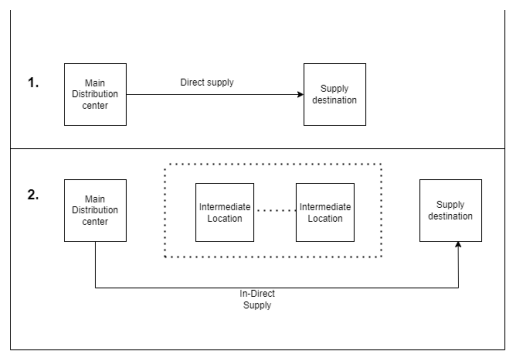

In [7]:
img = Image.open('/content/drive/MyDrive/Distribution.png')

plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In the above diagram
1. Direct Supply: Here sold to refers to only one ship to instance.
2. In-Direct Supply : Here one sold to refers to number of intermediate ships + 1 ships.

Let's consider an example: a big company like Walmart might order goods. Walmart's corporate office (the entity making the purchase) is the "sold to". But Walmart has many individual stores across the country/world. Each of these individual stores, like the Walmart in Chicago or the Walmart in New York, would be a "ship to" because they are the actual destinations where the goods are shipped


---


To put it in simple terms:

**Sold To**: Who you are billing (the entity buying the goods)

**Ship To**: Where you are delivering the goods

In [ ]:
# Display the first few rows of the dataset
print(data.head())

  shipto_customer_key local_product_code soldto_customer_key  sub_group_code  \
0    sh_ck_0004863994     lpc_0008051082    so_ck_0009205567  sgc_0004085550   
1    sh_ck_0001401747     lpc_0004650953    so_ck_0005626571  sgc_0008425668   
2    sh_ck_0000286497     lpc_0004797878    so_ck_0002209986  sgc_0009265879   
3    sh_ck_0009932568     lpc_0003295097    so_ck_0005712102  sgc_0002716860   
4    sh_ck_0005146308     lpc_0001240658    so_ck_0002584508  sgc_0004128529   

      group_code corporate_group_code product_producer_division_name  \
0  gc_0001515651       cgc_0003761208              pp_div_0002438336   
1  gc_0003292474       cgc_0001419508              pp_div_0007340086   
2  gc_0002516096       cgc_0007709331                            NaN   
3  gc_0005078263       cgc_0001419508              pp_div_0009996812   
4  gc_0001336533       cgc_0000381825              pp_div_0002733609   

  vertical_industry_1 vertical_industry_2 shipto_industry_code_level_1  \
0  vertind_0

In [ ]:
# Get a summary of the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143813 entries, 0 to 143812
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   shipto_customer_key             143813 non-null  object 
 1   local_product_code              143813 non-null  object 
 2   soldto_customer_key             143811 non-null  object 
 3   sub_group_code                  143807 non-null  object 
 4   group_code                      143807 non-null  object 
 5   corporate_group_code            143807 non-null  object 
 6   product_producer_division_name  90086 non-null   object 
 7   vertical_industry_1             143813 non-null  object 
 8   vertical_industry_2             143813 non-null  object 
 9   shipto_industry_code_level_1    143797 non-null  object 
 10  soldto_industry_code_level_1    143794 non-null  object 
 11  shipto_industry_code_level_2    143099 non-null  object 
 12  soldto_industry_

In [ ]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values for each column:\n", missing_values)

Missing values for each column:
 shipto_customer_key                   0
local_product_code                    0
soldto_customer_key                   2
sub_group_code                        6
group_code                            6
corporate_group_code                  6
product_producer_division_name    53727
vertical_industry_1                   0
vertical_industry_2                   0
shipto_industry_code_level_1         16
soldto_industry_code_level_1         19
shipto_industry_code_level_2        714
soldto_industry_code_level_2       1016
shipto_address_country                0
soldto_address_country                2
roll12m_gp                            0
roll12m_vol                           0
roll12m_rev                           0
dtype: int64


The Supplier name column has around 40% of missing data, if this info was available we could have also considered the **transportation efficiency** into consideration for recommendation engine algorithm. But as it's very sparse better to delete it.

In [128]:
data = data.drop(columns=["product_producer_division_name"])
data = data.dropna(subset=["shipto_industry_code_level_1","shipto_industry_code_level_2","shipto_industry_code_level_2","soldto_industry_code_level_2"])

In [129]:
data["level_1_shipto_soldto"]= np.where(data["shipto_industry_code_level_1"]==data["soldto_industry_code_level_1"],1,0)
data["level_2_shipto_soldto"]= np.where(data["shipto_industry_code_level_2"]==data["soldto_industry_code_level_2"],1,0)
np.allclose(data["level_1_shipto_soldto"],data["level_2_shipto_soldto"])

False

Confusion pertaining to **"sold to main industry vs sold to secondary industry"**.

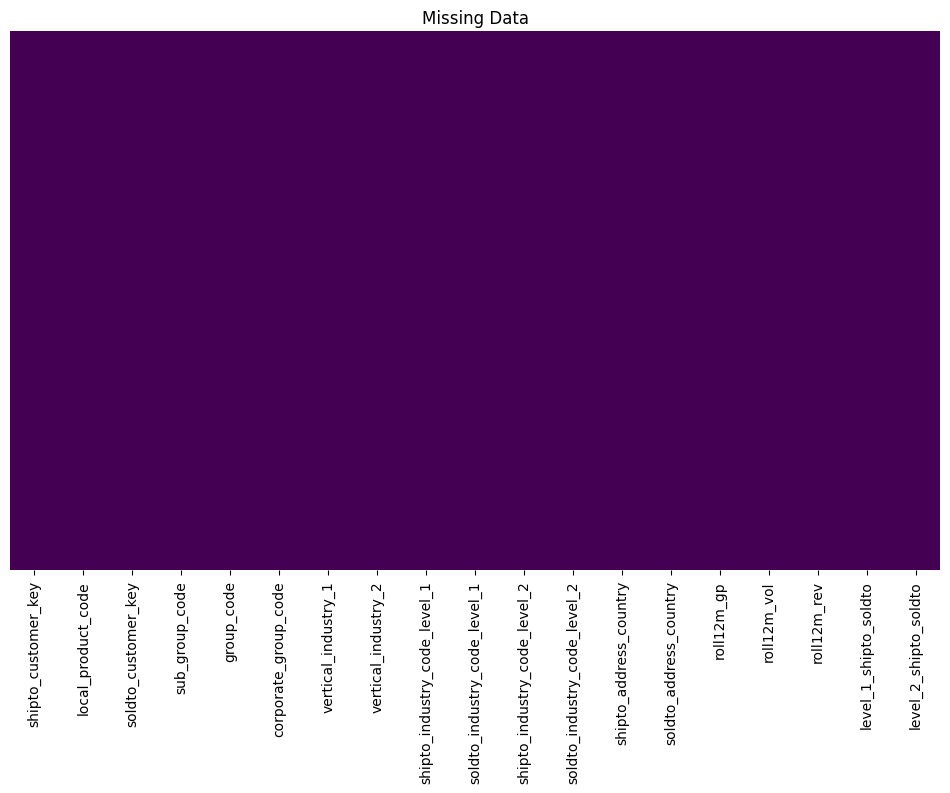

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data')
plt.show()

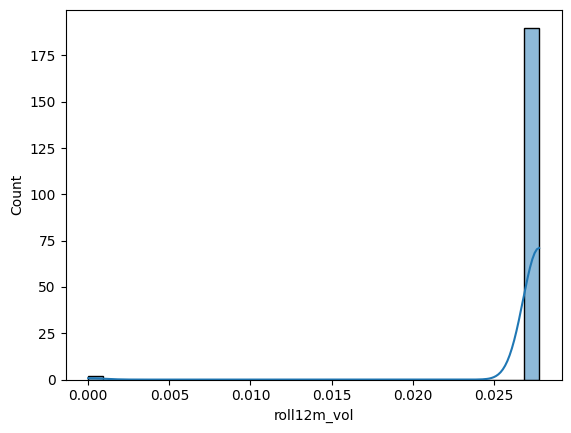

In [31]:
data_new = data[(data['roll12m_gp'] > -0.005) & (data['roll12m_gp'] < 0.005)]
data_new = data_new[(data_new['roll12m_vol']> 0.0) & (data_new['roll12m_vol'] < 0.03)]
sns.histplot(data_new['roll12m_vol'], bins=30, kde=True)
plt.show()

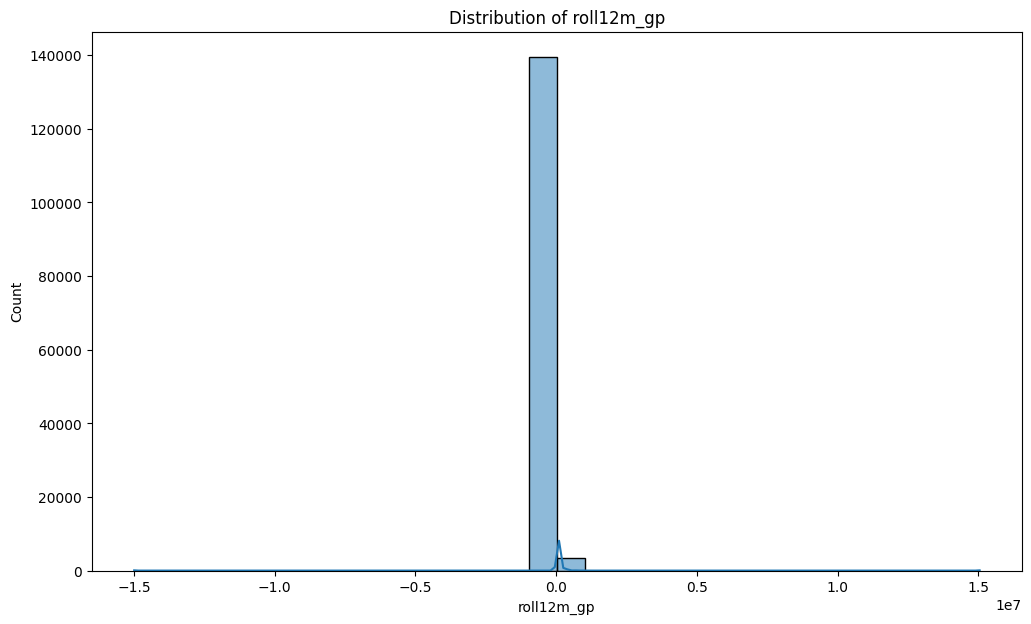

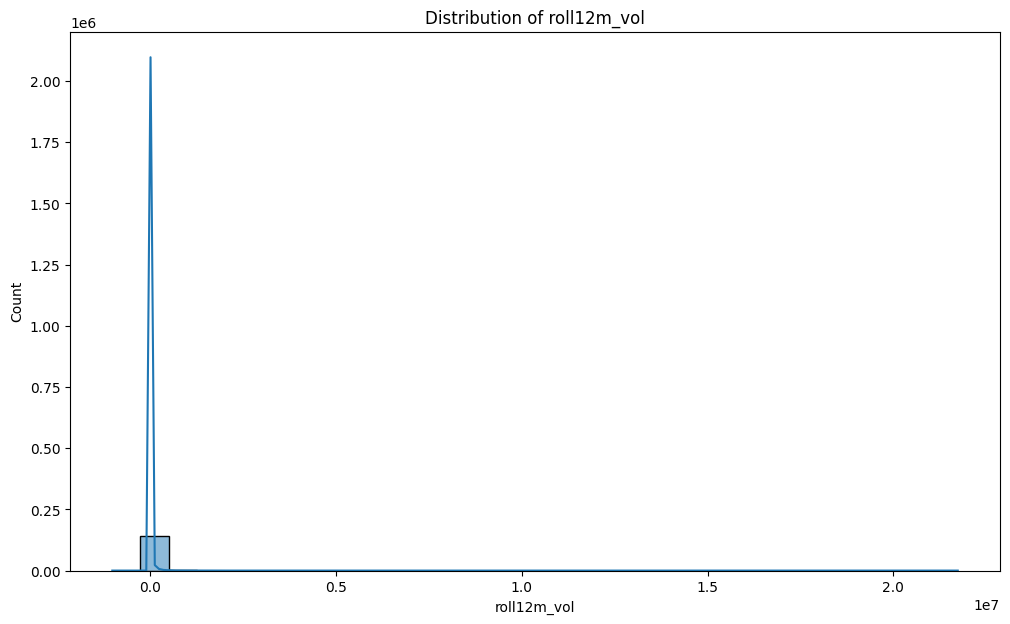

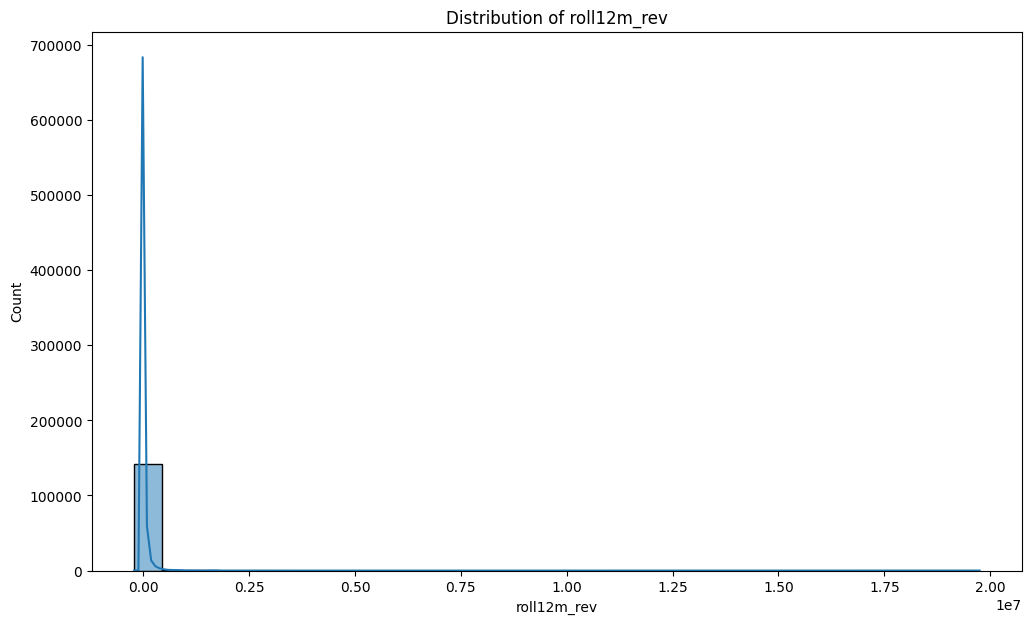

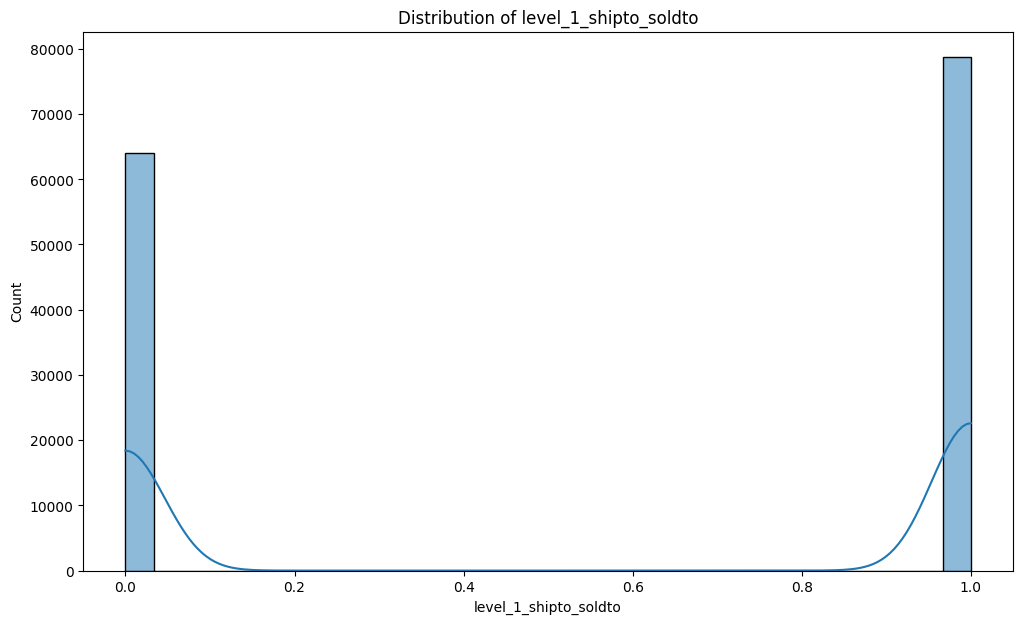

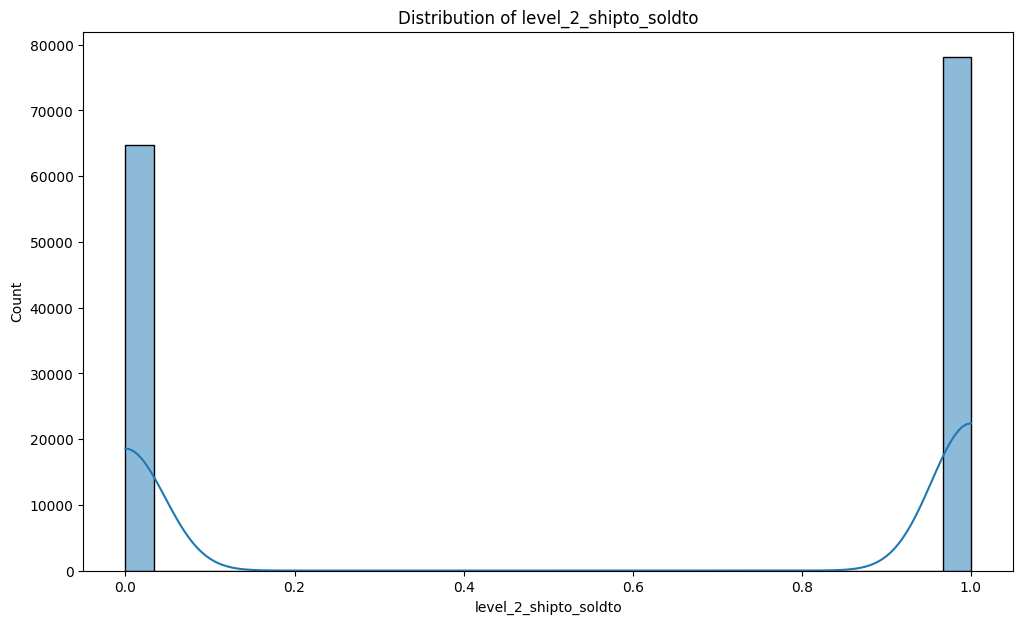

In [10]:
# Distribution of numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    plt.figure(figsize=(12, 7))
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

Remove Outliers

In [130]:
# Calculate IQR for the first column
Q1_column1 = data['roll12m_gp'].quantile(0.25)
Q3_column1 = data['roll12m_gp'].quantile(0.75)
IQR_column1 = Q3_column1 - Q1_column1

# Calculate IQR for the second column
Q1_column2 = data['roll12m_vol'].quantile(0.25)
Q3_column2 = data['roll12m_vol'].quantile(0.75)
IQR_column2 = Q3_column2 - Q1_column2

# Define outlier thresholds for each column
lower_bound_column1 = Q1_column1 - 1.5 * IQR_column1
upper_bound_column1 = Q3_column1 + 1.5 * IQR_column1
lower_bound_column2 = Q1_column2 - 1.5 * IQR_column2
upper_bound_column2 = Q3_column2 + 1.5 * IQR_column2

# Filter out the outliers
data_filtered = data[(data['roll12m_gp'] >= lower_bound_column1) & (data['roll12m_gp'] <= upper_bound_column1) &
                     (data['roll12m_vol'] >= lower_bound_column2) & (data['roll12m_vol'] <= upper_bound_column2)]



In [139]:
data_filtered['binned_gp'] = pd.cut(data_filtered['roll12m_gp'], bins=5, labels=[1, 2, 3, 4, 5]).astype('int')
data_filtered['binned_vol'] = pd.cut(data_filtered['roll12m_vol'], bins=5, labels=[1, 2, 3, 4, 5]).astype('int')


<ipython-input-139-108b8f612c0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['binned_gp'] = pd.cut(data_filtered['roll12m_gp'], bins=5, labels=[1, 2, 3, 4, 5]).astype('int')
<ipython-input-139-108b8f612c0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['binned_vol'] = pd.cut(data_filtered['roll12m_vol'], bins=5, labels=[1, 2, 3, 4, 5]).astype('int')


In [140]:
data_filtered['Ratings']= (data_filtered['binned_gp']+data_filtered['binned_vol'])/2

<ipython-input-140-8e79e3e48535>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Ratings']= (data_filtered['binned_gp']+data_filtered['binned_vol'])/2


In [142]:
np.std(np.array(data_filtered['Ratings']))

0.6611727283722404

In [143]:
np.mean(np.array(data_filtered["Ratings"]))

2.5926518708208848

In [144]:
data_filtered['Ratings'].max()

5.0

In [145]:
users_list = data_filtered['shipto_customer_key'].unique()
items_list = data_filtered['local_product_code'].unique()

In [ ]:
data.groupby("shipto_customer_key").count().sort_values('local_product_code', ascending=False)

,local_product_code,soldto_customer_key,sub_group_code,group_code,corporate_group_code,vertical_industry_1,vertical_industry_2,shipto_industry_code_level_1,soldto_industry_code_level_1,shipto_industry_code_level_2,...,soldto_address_country,roll12m_gp,roll12m_vol,roll12m_rev,level_1_shipto_soldto,level_2_shipto_soldto,feature1_minmax,feature2_minmax,feature3_minmax,Rating
shipto_customer_key,,,,,,,,,,,,,,,,,,,,,
sh_ck_0008977350,157,157,157,157,157,157,157,157,157,157,...,157,157,157,157,157,157,157,157,157,157
sh_ck_0008472975,142,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
sh_ck_0007657161,141,141,141,141,141,141,141,141,141,141,...,141,141,141,141,141,141,141,141,141,141
sh_ck_0002338261,135,135,135,135,135,135,135,135,135,135,...,135,135,135,135,135,135,135,135,135,135
sh_ck_0003843098,129,129,129,129,129,129,129,129,129,129,...,129,129,129,129,129,129,129,129,129,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sh_ck_0007403224,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
sh_ck_0003393693,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
sh_ck_0007404033,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [165]:
data.groupby("sub_group_code").count().sort_values('shipto_customer_key', ascending=False)

,shipto_customer_key,local_product_code,soldto_customer_key,group_code,corporate_group_code,vertical_industry_1,vertical_industry_2,shipto_industry_code_level_1,soldto_industry_code_level_1,shipto_industry_code_level_2,soldto_industry_code_level_2,shipto_address_country,soldto_address_country,roll12m_gp,roll12m_vol,roll12m_rev,level_1_shipto_soldto,level_2_shipto_soldto
sub_group_code,,,,,,,,,,,,,,,,,,
sgc_0005744755,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650,20650
sgc_0008425668,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018
sgc_0004085550,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743,3743
sgc_0004292243,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126,3126
sgc_0007056990,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sgc_0009375303,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
sgc_0008138281,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
sgc_0009355102,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Matrix Formulation**


In [147]:
matrix_filled = data_filtered.pivot_table(index='shipto_customer_key',
                          values=['Ratings'],
                          columns = ['sub_group_code'],
                          aggfunc='mean')

#matrix_filled = matrix.fillna()

matrix_filled = matrix_filled.notna().astype(int)


In [ ]:
matrix_filled[('Rating', 'sgc_0000020406')].reset_index()

,shipto_customer_key,Rating
,,sgc_0000020406
0,sh_ck_0000000119,0
1,sh_ck_0000000684,0
2,sh_ck_0000000739,0
3,sh_ck_0000001270,0
4,sh_ck_0000001272,0
...,...,...
31446,sh_ck_0009999063,0
31447,sh_ck_0009999744,0
31448,sh_ck_0009999746,0


In [204]:
import torch
import torch.nn as nn
import torch.optim as optim


data_tensor = torch.tensor(matrix_filled.values, dtype=torch.float32)


n_users, n_features = data_tensor.shape
n_components = 5

class BasicNMF(nn.Module):
    def __init__(self, n_users, n_features, n_components):
        super(BasicNMF, self).__init__()
        self.user_features = nn.Parameter(torch.rand(n_users, n_components))
        self.item_features = nn.Parameter(torch.rand(n_components, n_features))

    def forward(self):
        prediction = torch.matmul(self.user_features, self.item_features)
        return prediction

model = BasicNMF(n_users, n_features, n_components)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model()
    loss = criterion(output, data_tensor)
    loss.backward()
    optimizer.step()


    with torch.no_grad():
        model.user_features.clamp_(min=0)
        model.item_features.clamp_(min=0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

final_user_features = model.user_features.detach()
final_item_features = model.item_features.detach()

final_user_features, final_item_features


Epoch 1/100, Loss: 1.7927258014678955
Epoch 11/100, Loss: 0.8431575298309326
Epoch 21/100, Loss: 0.4086434543132782
Epoch 31/100, Loss: 0.2180161029100418
Epoch 41/100, Loss: 0.13073253631591797
Epoch 51/100, Loss: 0.08686602115631104
Epoch 61/100, Loss: 0.0624537318944931
Epoch 71/100, Loss: 0.04754534363746643
Epoch 81/100, Loss: 0.03769982233643532
Epoch 91/100, Loss: 0.030793724581599236


(tensor([[0.0000, 0.3483, 0.0000, 0.2871, 0.0000],
         [0.4320, 0.1958, 0.1549, 0.0000, 0.5065],
         [0.1006, 0.5155, 0.0000, 0.3849, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3957, 0.4745, 0.0000],
         [0.4201, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4561, 0.2801, 0.0000, 0.0000]]),
 tensor([[0.2096, 0.0259, 0.0000,  ..., 0.1112, 0.0000, 0.4403],
         [0.0000, 0.1770, 0.0831,  ..., 0.0000, 0.1595, 0.0000],
         [0.4435, 0.5137, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2951, 0.4941, 0.0000,  ..., 0.3424, 0.0000, 0.4717],
         [0.0000, 0.0284, 0.3029,  ..., 0.2742, 0.4428, 0.0000]]))

In [206]:
test_output = model()

differences = torch.abs(test_output - data_tensor)
good_predictions = (differences <= 0.25).float()
accuracy = torch.mean(good_predictions).item()

print(f'Accuracy: {accuracy * 100}%')


Accuracy: 89.26206231117249%


In [208]:
#Get the index from the unique list of users, to get the index of products refer products list.
user_index = 0
user_features = model.user_features[user_index]

predicted_ratings = torch.matmul(user_features, model.item_features).detach()

item_index = 0
predicted_rating_for_item = round(predicted_ratings[item_index].item(),1)

print(f"Predicted rating for user {user_index} for item {item_index} is: {predicted_rating_for_item}")


Predicted rating for user 0 for item 0 is: 0.1


In [148]:
!pip install scikit-surprise



In [150]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))  # Adjust the scale according to your dataset
data_new = Dataset.load_from_df(data_filtered[['shipto_customer_key', 'sub_group_code', 'Ratings']], reader)

trainset, testset = train_test_split(data_new, test_size=0.2, random_state=42)

svd = SVD(random_state=0, n_factors=200, n_epochs=30, verbose=True)
svd.fit(trainset)

user_factors = svd.pu
item_factors_internal_index = svd.qi

item_factors = [svd.trainset.to_raw_iid(i) for i in range(len(item_factors_internal_index))]

print("User factors matrix shape:", user_factors.shape)
print("Item factors matrix shape:", item_factors_internal_index.shape)

print("Unique item IDs:", item_factors)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
User factors matrix shape: (25690, 200)
Item factors matrix shape: (748, 200)
Unique item IDs: ['sgc_0007056990', 'sgc_0005744755', 'sgc_0000271760', 'sgc_0005323277', 'sgc_0009266536', 'sgc_0009214954', 'sgc_0006043507', 'sgc_0001870999', 'sgc_0003487588', 'sgc_0008236214', 'sgc_0004085550', 'sgc_0001587417', 'sgc_0009934246', 'sgc_0005476289', 'sgc_0000894437', 'sgc_0000996026', 'sgc_0000091612', 'sgc_000

In [151]:
predictions = svd.test(testset)
column_names = ['uid','iid','rating_user','predicted_value','details']
predicted_set = pd.DataFrame(predictions, columns = column_names)
predicted_set

,uid,iid,rating_user,predicted_value,details
0,sh_ck_0005741010,sgc_0007958949,2.5,2.632859,{'was_impossible': False}
1,sh_ck_0007704111,sgc_0007718982,2.0,2.684408,{'was_impossible': False}
2,sh_ck_0006834413,sgc_0009888822,2.5,2.831102,{'was_impossible': False}
3,sh_ck_0003912592,sgc_0009358786,3.5,2.955524,{'was_impossible': False}
4,sh_ck_0002638102,sgc_0007870140,3.0,3.010391,{'was_impossible': False}
...,...,...,...,...,...
22488,sh_ck_0005996597,sgc_0007056990,2.0,2.119229,{'was_impossible': False}
22489,sh_ck_0003234676,sgc_0007898506,3.5,2.929245,{'was_impossible': False}
22490,sh_ck_0005306032,sgc_0005413192,3.5,3.070395,{'was_impossible': False}
22491,sh_ck_0005323308,sgc_0008190242,2.0,2.706675,{'was_impossible': False}


In [190]:
def is_good_50(a):
  if abs(a['predicted_value']-a['rating_user'])<0.5:
    return 1
  else:
    return 0
def is_good_60(a):
  if abs(a['predicted_value']-a['rating_user'])<0.6:
    return 1
  else:
    return 0

In [194]:
predicted_set["is_good_50"] = predicted_set.apply(is_good_50, axis = 1)
predicted_set["is_good_60"] = predicted_set.apply(is_good_60, axis = 1)
print("Accuracy of the datset prediction with 0.5 band width ",round(predicted_set['is_good_50'].mean(),2))
print("Accuracy of the datset prediction with 0.6 band width ",round(predicted_set['is_good_60'].mean(),2))

Accuracy of the datset prediction with 0.5 band width  0.7
Accuracy of the datset prediction with 0.6 band width  0.76


In [152]:
svd.predict('sh_ck_0002036295','sgc_0000030989')

Prediction(uid='sh_ck_0002036295', iid='sgc_0000030989', r_ui=None, est=3.331762057172841, details={'was_impossible': False})

In [153]:
def top_k_products(k,user_id, items_list, matrix_filled):
  new_pd_column = matrix_filled.loc[user_id].reset_index()
  new_pd_column = new_pd_column[new_pd_column[user_id]==0]
  not_reviewed= new_pd_column['sub_group_code'].tolist()
  total_values = {j: svd.predict(user_id, j)[3] for j in not_reviewed}
  sorted_list = sorted(total_values.items(), key=lambda item: item[1], reverse = True)
  top_k = sorted_list[:k]
  return top_k

In [155]:
top_k_products(10,'sh_ck_0002036295',items_list,matrix_filled)

[('sgc_0005969671', 3.7286172702239164),
 ('sgc_0002778691', 3.717380857615315),
 ('sgc_0001587417', 3.663163337320664),
 ('sgc_0006707443', 3.660333316383709),
 ('sgc_0009214954', 3.653280426182218),
 ('sgc_0000988939', 3.5874494657077283),
 ('sgc_0005438959', 3.57323470732131),
 ('sgc_0007887339', 3.570594810319167),
 ('sgc_0002228922', 3.5661773328776),
 ('sgc_0009198775', 3.5410366372181423)]

In [167]:
def top_k_users(k,item_id, users_list, matrix_filled):
  col_1 = np.array(matrix_filled[('Ratings', item_id)].reset_index()[('shipto_customer_key', '')]).reshape(27800,1)
  col_2 = np.array(matrix_filled[('Ratings', item_id)].reset_index()[('Ratings', item_id)]).reshape(27800,1)
  new_pd_column=pd.DataFrame(np.concatenate((col_1, col_2), axis=1), columns = ['id','is_reviewed'])
  new_pd_column = new_pd_column[new_pd_column['is_reviewed']==0]
  not_reviewed= new_pd_column['id'].tolist()
  total_values = {j: svd.predict(item_id, j)[3] for j in not_reviewed}
  sorted_list = sorted(total_values.items(), key=lambda item: item[1], reverse = True)
  top_k = sorted_list[:k]
  return top_k